# Model tracking

## Naive tracking with PyTorch

Let's consider the following simple toy model (multilayer perceptron) training code.

First, we need to do the necessary imports:

In [1]:
# Import needed modules
import torch

from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

from torch import nn

from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np

Then we need to set up datasets and data loaders:

In [2]:
# Set up datasets and data loaders

data_dir = "../data"

batch_size = 32

train_dataset = datasets.MNIST(
    data_dir, train=True, download=True, transform=ToTensor()
)
test_dataset = datasets.MNIST(data_dir, train=False, transform=ToTensor())

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Then we'll need to specify a model (in this case a toy multilayer perceptron model):

In [3]:
# Specify model

device = "cuda" if torch.cuda.is_available() else "cpu"

class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(), nn.Linear(28 * 28, 20), nn.ReLU(), nn.Linear(20, 10)
        )

    def forward(self, x):
        return self.layers(x)


model = SimpleMLP().to(device)
print(model)

SimpleMLP(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=20, bias=True)
    (2): ReLU()
    (3): Linear(in_features=20, out_features=10, bias=True)
  )
)


Then we specify the loss criterion and optimizer:

In [4]:
# Specify loss and optimizer

criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters())

### Tracking in training loop

A naive approach to tracking is to record some values in the training loop and then store those values into some Python objects (like lists).

In this example we record the loss and the number of correct predictions:

In [5]:
# Train the model

model.train()

num_batches = len(train_loader)
num_items = len(train_loader.dataset)
losses = []
accuracies = []
epochs = 5

for epoch in range(epochs):
    total_loss = 0
    total_correct = 0
    for data, target in tqdm(train_loader, total=num_batches):
        # Copy data and targets to GPU
        data = data.to(device)
        target = target.to(device)

        # Do a forward pass
        outputs = model(data)

        # Calculate the loss
        loss = criterion(outputs, target)
        total_loss += loss.item()

        # Count number of correct digits
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == target).sum().item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    train_loss = total_loss / num_batches
    accuracy = total_correct / num_items
    print(f"Average loss: {train_loss:7f}, accuracy: {accuracy:.2%}")
    losses.append(train_loss)
    accuracies.append(accuracy)

100%|██████████| 1875/1875 [00:03<00:00, 492.65it/s]


Average loss: 0.426173, accuracy: 88.43%


100%|██████████| 1875/1875 [00:03<00:00, 507.50it/s]


Average loss: 0.242262, accuracy: 93.12%


100%|██████████| 1875/1875 [00:03<00:00, 504.96it/s]


Average loss: 0.198319, accuracy: 94.34%


100%|██████████| 1875/1875 [00:03<00:00, 502.73it/s]


Average loss: 0.170984, accuracy: 95.12%


100%|██████████| 1875/1875 [00:03<00:00, 518.98it/s]

Average loss: 0.152985, accuracy: 95.57%


After the training has finished, we can then plot those values:

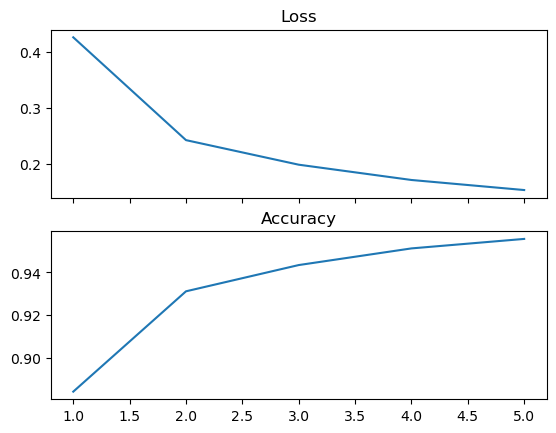

In [6]:
batch_index = np.arange(1, len(losses) + 1)

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)

ax1.plot(batch_index, np.asarray(losses))
ax1.set_title("Loss")
ax2.plot(batch_index, np.asarray(accuracies))
ax2.set_title("Accuracy")

fig.show()

## Better approach - Tensorboard

Lets use Tensorboard to capture the output.

[Tensorboard](https://www.tensorflow.org/tensorboard) is Tensorflow's visualization toolkit, but it is also [supported by PyTorch](https://docs.pytorch.org/tutorials/intermediate/tensorboard_tutorial.html).

PyTorch provides a class called [torch.utils.tensorboard.SummaryWriter](https://docs.pytorch.org/docs/stable/tensorboard.html#module-torch.utils.tensorboard) that can be used to write output into Tensorflow:

In [7]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(log_dir="tensorflow_logs/mnist_example")

Let's reset the model and optimizer:

In [8]:
model = SimpleMLP().to(device)

optimizer = torch.optim.AdamW(model.parameters())

### Model visualization

We can use Tensorboard to visualize the model.

To do this we need to get some example images from our dataloader.

In [9]:
example_data, example_labels = next(iter(train_loader))
example_data = example_data.to(device)
example_labels = example_labels.to(device)

Now we can visualize the model as graph by giving the writer our model and our example input data: 

In [10]:
writer.add_graph(model, example_data)
writer.close()

### Tracking model performance

Let's add Tensorboard tracking to our training code:

In [11]:
# Train the model

model.train()

num_batches = len(train_loader)
num_items = len(train_loader.dataset)
epochs = 5

for epoch in range(epochs):
    total_loss = 0
    total_correct = 0
    for data, target in tqdm(train_loader, total=num_batches):
        # Copy data and targets to GPU
        data = data.to(device)
        target = target.to(device)

        # Do a forward pass
        outputs = model(data)

        # Calculate the loss
        loss = criterion(outputs, target)
        total_loss += loss.item()

        # Count number of correct digits
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == target).sum().item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    train_loss = total_loss / num_batches
    accuracy = total_correct / num_items
    writer.add_scalar('Loss', train_loss, epoch+1)
    writer.add_scalar('Accuracy', accuracy, epoch+1)
    print(f"Average loss: {train_loss:7f}, accuracy: {accuracy:.2%}")

100%|██████████| 1875/1875 [00:03<00:00, 512.78it/s]


Average loss: 0.431756, accuracy: 88.44%


100%|██████████| 1875/1875 [00:03<00:00, 512.62it/s]


Average loss: 0.247227, accuracy: 92.88%


100%|██████████| 1875/1875 [00:03<00:00, 515.30it/s]


Average loss: 0.207336, accuracy: 94.05%


100%|██████████| 1875/1875 [00:03<00:00, 502.05it/s]


Average loss: 0.182222, accuracy: 94.75%


100%|██████████| 1875/1875 [00:03<00:00, 513.83it/s]

Average loss: 0.163930, accuracy: 95.28%


## Launching Tensorboard

Tensorboard launches a web server to view its data. You can view this server in a notebook or you can connect to this server with the web browser.

In most cases the Tensorboard server port is usually not open to the wider world, so you need to do something like
```sh
ssh jupyternode -J loginnode -L 6006:localhost:6006
```
and then run
```python
import os
os.environ["TENSORBOARD_PROXY_URL"]="http://localhost:6006"
```
to create a ssh proxy tunnel to the server. In some cases you can also just run

```jupyter
%load_ext tensorboard
```

```jupyter
%tensorboard --logdir tensorflow_logs/mnist_example
```
to open Tensorboard in a notebook.

Alternatively, you can launch Tensorboard in your own machine if you just copy the event logs to your computer.